In [1]:
import ehrapy as ep
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [2]:
VAR_OF_INTEREST = "num_medications"

In [3]:
adata = ep.dt.diabetes_130_fairlearn()

In [4]:
# create reproducible MCAR missing values
rng = np.random.default_rng(2)
mcar_mask = rng.choice([True, False], size=len(adata), p=[0.3, 0.7])
# create a new AnnData with these missing values
adata_mcar = adata.copy()
adata_mcar.X[mcar_mask, adata_mcar.var_names == VAR_OF_INTEREST] = np.nan

In [5]:
adata_mcar_mean_imputed = ep.pp.simple_impute(
    adata_mcar, var_names=[VAR_OF_INTEREST], strategy="mean", copy=True
)

Output()

In [6]:
adata_mcar_limited = adata_mcar[
    :, adata_mcar.var_names.isin([VAR_OF_INTEREST, "time_in_hospital"])
].copy()

In [7]:
ep.ad.infer_feature_types(adata_mcar_limited)

❗ Feature 'time_in_hospital' was detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.


 Detected feature types for AnnData object with 101766 obs and 2 vars
╠══ 📅 Date features
╠══ 📐 Numerical features
║   ╚══ num_medications
╚══ 🗂️ Categorical features
    ╚══ time_in_hospital (14 categories)

In [8]:
adata_group = adata[:, adata.var_names.isin([VAR_OF_INTEREST, "time_in_hospital"])]

# admission_source_encoded = adata_group_encoded[:, adata_group_encoded.var_names == f"ehrapycat_{GROUP_VAR}"].X
value_vector = adata[:, adata.var_names == "time_in_hospital"].X.astype(np.float64)

continuous_values = np.array(value_vector - np.mean(value_vector)) / np.std(
    value_vector
)
# small offset to steer the degree of missingness
continuous_values *= 1.2
continuous_values -= 0.6

# Convert continuous values to probabilities using the logistic function
probabilities = 1 / (1 + np.exp(-continuous_values))
probabilities

# Generate MAR mask based on probabilities
rng = np.random.default_rng(2)
mar_mask = rng.binomial(1, probabilities).astype(bool)

adata_group_encoded_mar = adata_group.copy()
adata_group_encoded_mar.X[
    mar_mask.flatten(), adata_group_encoded_mar.var_names == VAR_OF_INTEREST
] = np.nan

In [9]:
# missingness percentage
print(
    f"{mar_mask.flatten().sum()/len(mar_mask):.2%} missing data introduced in MAR scenario"
)

36.86% missing data introduced in MAR scenario


In [10]:
adata_mar_mean_imputed = ep.pp.simple_impute(
    adata_group_encoded_mar, var_names=[VAR_OF_INTEREST], strategy="mean", copy=True
)

Output()

In [11]:
adata_mar_mi_imputed = ep.pp.miss_forest_impute(adata_group_encoded_mar, copy=True)

Output()

❗ The number of jobs is only 1. To decrease the runtime set ep.settings.n_jobs=-1.


In [12]:
mean_complete = np.nanmean(
    adata[:, adata.var_names == VAR_OF_INTEREST].X.astype(np.float64)
)
mean_mcar = np.nanmean(
    adata_mcar[:, adata_mcar.var_names == VAR_OF_INTEREST].X.astype(np.float64)
)
mean_mcar_mean_imputed = np.nanmean(
    adata_mcar_mean_imputed[
        :, adata_mcar_mean_imputed.var_names == VAR_OF_INTEREST
    ].X.astype(np.float64)
)
mean_mar = np.nanmean(
    adata_group_encoded_mar[
        :, adata_group_encoded_mar.var_names == VAR_OF_INTEREST
    ].X.astype(np.float64)
)
mean_mar_mean_imputed = np.nanmean(
    adata_mar_mean_imputed[
        :, adata_mar_mean_imputed.var_names == VAR_OF_INTEREST
    ].X.astype(np.float64)
)
mean_mar_mi_imputed = np.nanmean(
    adata_mar_mi_imputed[:, adata_mar_mi_imputed.var_names == VAR_OF_INTEREST].X.astype(
        np.float64
    )
)

std_complete = np.nanstd(
    adata[:, adata.var_names == VAR_OF_INTEREST].X.astype(np.float64)
)
std_mcar = np.nanstd(
    adata_mcar[:, adata_mcar.var_names == VAR_OF_INTEREST].X.astype(np.float64)
)
std_mcar_mean_imputed = np.nanstd(
    adata_mcar_mean_imputed[
        :, adata_mcar_mean_imputed.var_names == VAR_OF_INTEREST
    ].X.astype(np.float64)
)
std_mar = np.nanstd(
    adata_group_encoded_mar[
        :, adata_group_encoded_mar.var_names == VAR_OF_INTEREST
    ].X.astype(np.float64)
)
std_mar_mean_imputed = np.nanstd(
    adata_mar_mean_imputed[
        :, adata_mar_mean_imputed.var_names == VAR_OF_INTEREST
    ].X.astype(np.float64)
)
std_mar_mi_imputed = np.nanstd(
    adata_mar_mi_imputed[:, adata_mar_mi_imputed.var_names == VAR_OF_INTEREST].X.astype(
        np.float64
    )
)

df_mcar = pd.DataFrame(
    {
        "Complete": [mean_complete, std_complete],
        "MCAR": [mean_mcar, std_mcar],
        "MCAR Mean Imputed": [mean_mcar_mean_imputed, std_mcar_mean_imputed],
    },
    index=["Mean", "Stdev"],
)
df_mcar.style.format("{:.2f}")

,Complete,MCAR,MCAR Mean Imputed
Mean,16.02,16.02,16.02
Stdev,8.13,8.14,6.81


In [13]:
df_mar = pd.DataFrame(
    {
        "Complete": [mean_complete, std_complete],
        "MAR": [mean_mar, std_mar],
        "MAR Mean Imputed": [mean_mar_mean_imputed, std_mar_mean_imputed],
        "MAR MI Imputed": [mean_mar_mi_imputed, std_mar_mi_imputed],
    },
    index=["Mean", "Stdev"],
)
df_mar.style.format("{:.2f}")

,Complete,MAR,MAR Mean Imputed,MAR MI Imputed
Mean,16.02,14.66,14.66,16.04
Stdev,8.13,7.20,5.72,6.45


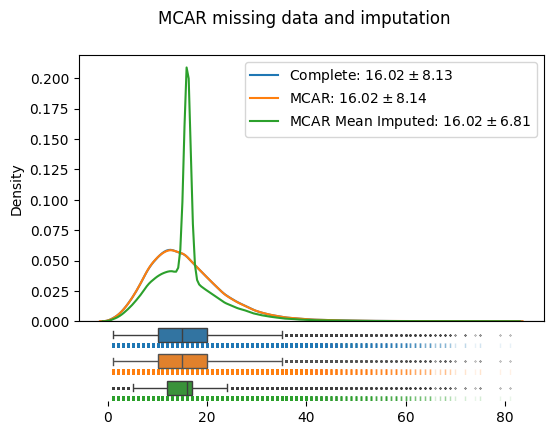

In [14]:
labels = ("Complete", "MCAR", "MCAR Mean Imputed")
adatas = (adata, adata_mcar, adata_mcar_mean_imputed)
colors = sns.color_palette("tab10")[: len(adatas)]

height_ratios = [10] + [1] * len(adatas)

# Create the subplots with specified height ratios
fig, axes = plt.subplots(
    nrows=1 + len(adatas),
    figsize=(6, 1.5 * len(adatas)),
    gridspec_kw={"height_ratios": height_ratios},
    sharex=True,
)
fig.subplots_adjust(hspace=0)

for i, (color, label, data) in enumerate(zip(colors, labels, adatas)):
    statistics = df_mcar.iloc[:, i]
    stat_string = f"${round(statistics['Mean'].item(), 2)} \pm {round(statistics['Stdev'].item(), 2)}$"

    sns.kdeplot(
        x=data[:, data.var_names == VAR_OF_INTEREST].X.flatten(),
        color=color,
        ax=axes[0],
        label=f"{label}: {stat_string}",
    )
    sns.boxplot(
        x=data[:, data.var_names == VAR_OF_INTEREST].X.flatten(),
        orient="h",
        color=color,
        ax=axes[i + 1],
        width=0.25,
        fliersize=0.3,
    )
    sns.rugplot(
        x=data[:, data.var_names == VAR_OF_INTEREST].X.flatten(),
        color=color,
        alpha=0.1,
        ax=axes[i + 1],
        height=0.2,
    )

    axes[i + 1].spines["right"].set_visible(False)
    axes[i + 1].spines["left"].set_visible(False)
    axes[i + 1].spines["bottom"].set_visible(False)
    axes[i + 1].set_yticks([])

    if i > 0:
        axes[i + 1].spines["top"].set_visible(False)

fig.suptitle(
    "MCAR missing data and imputation",
)
axes[0].legend()

plt.savefig("missing-data_imputation_bias_mcar.png", dpi=300, bbox_inches="tight")

In [ ]:
# Warning: the svg image generated is big, >60MB
plt.savefig("missing-data_imputation_bias_mcar.svg", dpi=300, bbox_inches="tight")

In [15]:
labels = ("Complete", "MAR", "MAR Mean Imputed", "MAR MissForest Imputed")
adatas = (adata, adata_group_encoded_mar, adata_mar_mean_imputed, adata_mar_mi_imputed)
colors = sns.color_palette("tab10")[: len(adatas)]

height_ratios = [10] + [1] * len(adatas)

# Create the subplots with specified height ratios
fig, axes = plt.subplots(
    nrows=1 + len(adatas),
    figsize=(6, 1.5 * len(adatas)),
    gridspec_kw={"height_ratios": height_ratios},
    sharex=True,
)
fig.subplots_adjust(hspace=0)

for i, (color, label, data) in enumerate(zip(colors, labels, adatas)):
    statistics = df_mar.iloc[:, i]
    stat_string = f"${round(statistics['Mean'].item(), 2)} \pm {round(statistics['Stdev'].item(), 2)}$"

    sns.kdeplot(
        x=data[:, data.var_names == VAR_OF_INTEREST].X.flatten(),
        color=color,
        ax=axes[0],
        label=f"{label}: {stat_string}",
    )
    sns.boxplot(
        x=data[:, data.var_names == VAR_OF_INTEREST].X.flatten(),
        orient="h",
        color=color,
        ax=axes[i + 1],
        width=0.25,
        fliersize=0.3,
    )
    sns.rugplot(
        x=data[:, data.var_names == VAR_OF_INTEREST].X.flatten(),
        color=color,
        alpha=0.1,
        ax=axes[i + 1],
        height=0.2,
    )

    axes[i + 1].spines["right"].set_visible(False)
    axes[i + 1].spines["left"].set_visible(False)
    axes[i + 1].spines["bottom"].set_visible(False)
    axes[i + 1].set_yticks([])

    if i > 0:
        axes[i + 1].spines["top"].set_visible(False)

fig.suptitle(
    "MAR missing data and imputation",
)
axes[0].legend()

plt.savefig("missing-data_imputation_bias_mar.png", dpi=300, bbox_inches="tight")


In [ ]:
# Warning: the svg image generated is big, >60MB
plt.savefig("missing-data_imputation_bias_mar.svg", dpi=300, bbox_inches="tight")